# Spatial Metrics
Calculating various spatial metrics for downstream analysis

**Main output**
- [distance_matrices]({output_path}/spatial_metrics/distance_matrices): per sample pairwise (cell:cell) euclidean distances
- [connectivity_graph]({output_path}/spatial_metrics/connectivity_graphs/connectivities_rad{radius}.csv): Connectivity graph representing cell:cell connections at 1500px radius. Annotations included for interacting cells.
- [neighborhoods_cell_level]({output_path}/spatial_metrics/neighborhoods_cell_level/cell_neighborhood_proportions_rad{radius}.csv): For cell-level neighborhoods at varying distances, proportions of cellypes are reported.
- [neighborhoods_sample_level]({output_path}/spatial_metrics/neighborhoods_sample_level/neighborhoods_avergaged_ranges_0to1500.csv): per sample, averaged neighborhood proportionds for each celltype. Calculcated for a range of radii
- [shannon_diversity]({output_path}/spatial_metrics/shannon_diversity/shannon_diversity_across_radii.csv): Shannon diversity index calculates for neighborhoods of each celltype at varying radii

In [1]:
from auxFns import styles as sy
from auxFns import tap1_auxfns

import polars as pl
import scanpy as sc
import anndata as ad
import plotnine as pn
from plotnine import ggplot, aes
import pandas as pd

In [2]:
# output_path = '/home/ubuntu/code/notebooks/tickets/TAP1/output'
# output_path = '/home/ubuntu/code/notebooks/tickets/TAP1/output'
output_path = '/Users/cameronpark/Desktop/output_v1'

### read annotated adata file

In [3]:
adata = ad.read_h5ad(f'{output_path}/h5ad/inSitu/tap1_harmonized_dist-0.01_spread-1_fine_annotated.h5ad')

In [4]:
### combine AML and Myeloid
adata.obs['transferred_ctype'] = adata.obs['transferred_ctype'].astype('str')
aml = adata[adata.obs.transferred_ctype == "AML"]
myeloid = adata[adata.obs.transferred_ctype == "Myeloid"]
adata.obs.loc[aml.obs.index,'transferred_ctype'] = "AML/Myeloid"
adata.obs.loc[myeloid.obs.index,'transferred_ctype'] = "AML/Myeloid"

adata.obs['transferred_ctype'] = adata.obs['transferred_ctype'].astype('category')


adata.obs['celltype_fine'] = adata.obs['celltype_fine'].astype('str')
aml = adata[adata.obs.celltype_fine == "AML"]
myeloid = adata[adata.obs.celltype_fine == "Myeloid"]
adata.obs.loc[aml.obs.index,'celltype_fine'] = "AML/Myeloid"
adata.obs.loc[myeloid.obs.index,'celltype_fine'] = "AML/Myeloid"

adata.obs['celltype_fine'] = adata.obs['celltype_fine'].astype('category')


df = pd.DataFrame(adata.X.todense(), index = adata.obs.index, columns = adata.var.index)
df['celltype'] = adata.obs['transferred_ctype']
df_sub = df[df['celltype']=='AML/Myeloid']
df_sub2 = df_sub[df_sub['CD34']>0]

cd34 = adata.obs.loc[df_sub2.index]


adata.obs['transferred_ctype'] = adata.obs['transferred_ctype'].astype(str)
adata.obs.loc[cd34.index,'transferred_ctype'] = "AML/Myeloid-cd34+"
adata.obs['transferred_ctype'] = adata.obs['transferred_ctype'].astype('category')


adata.obs['celltype_fine'] = adata.obs['celltype_fine'].astype(str)
adata.obs.loc[cd34.index,'celltype_fine'] = "AML/Myeloid-cd34+"
adata.obs['celltype_fine'] = adata.obs['celltype_fine'].astype('category')

### spatial overview of sample composition

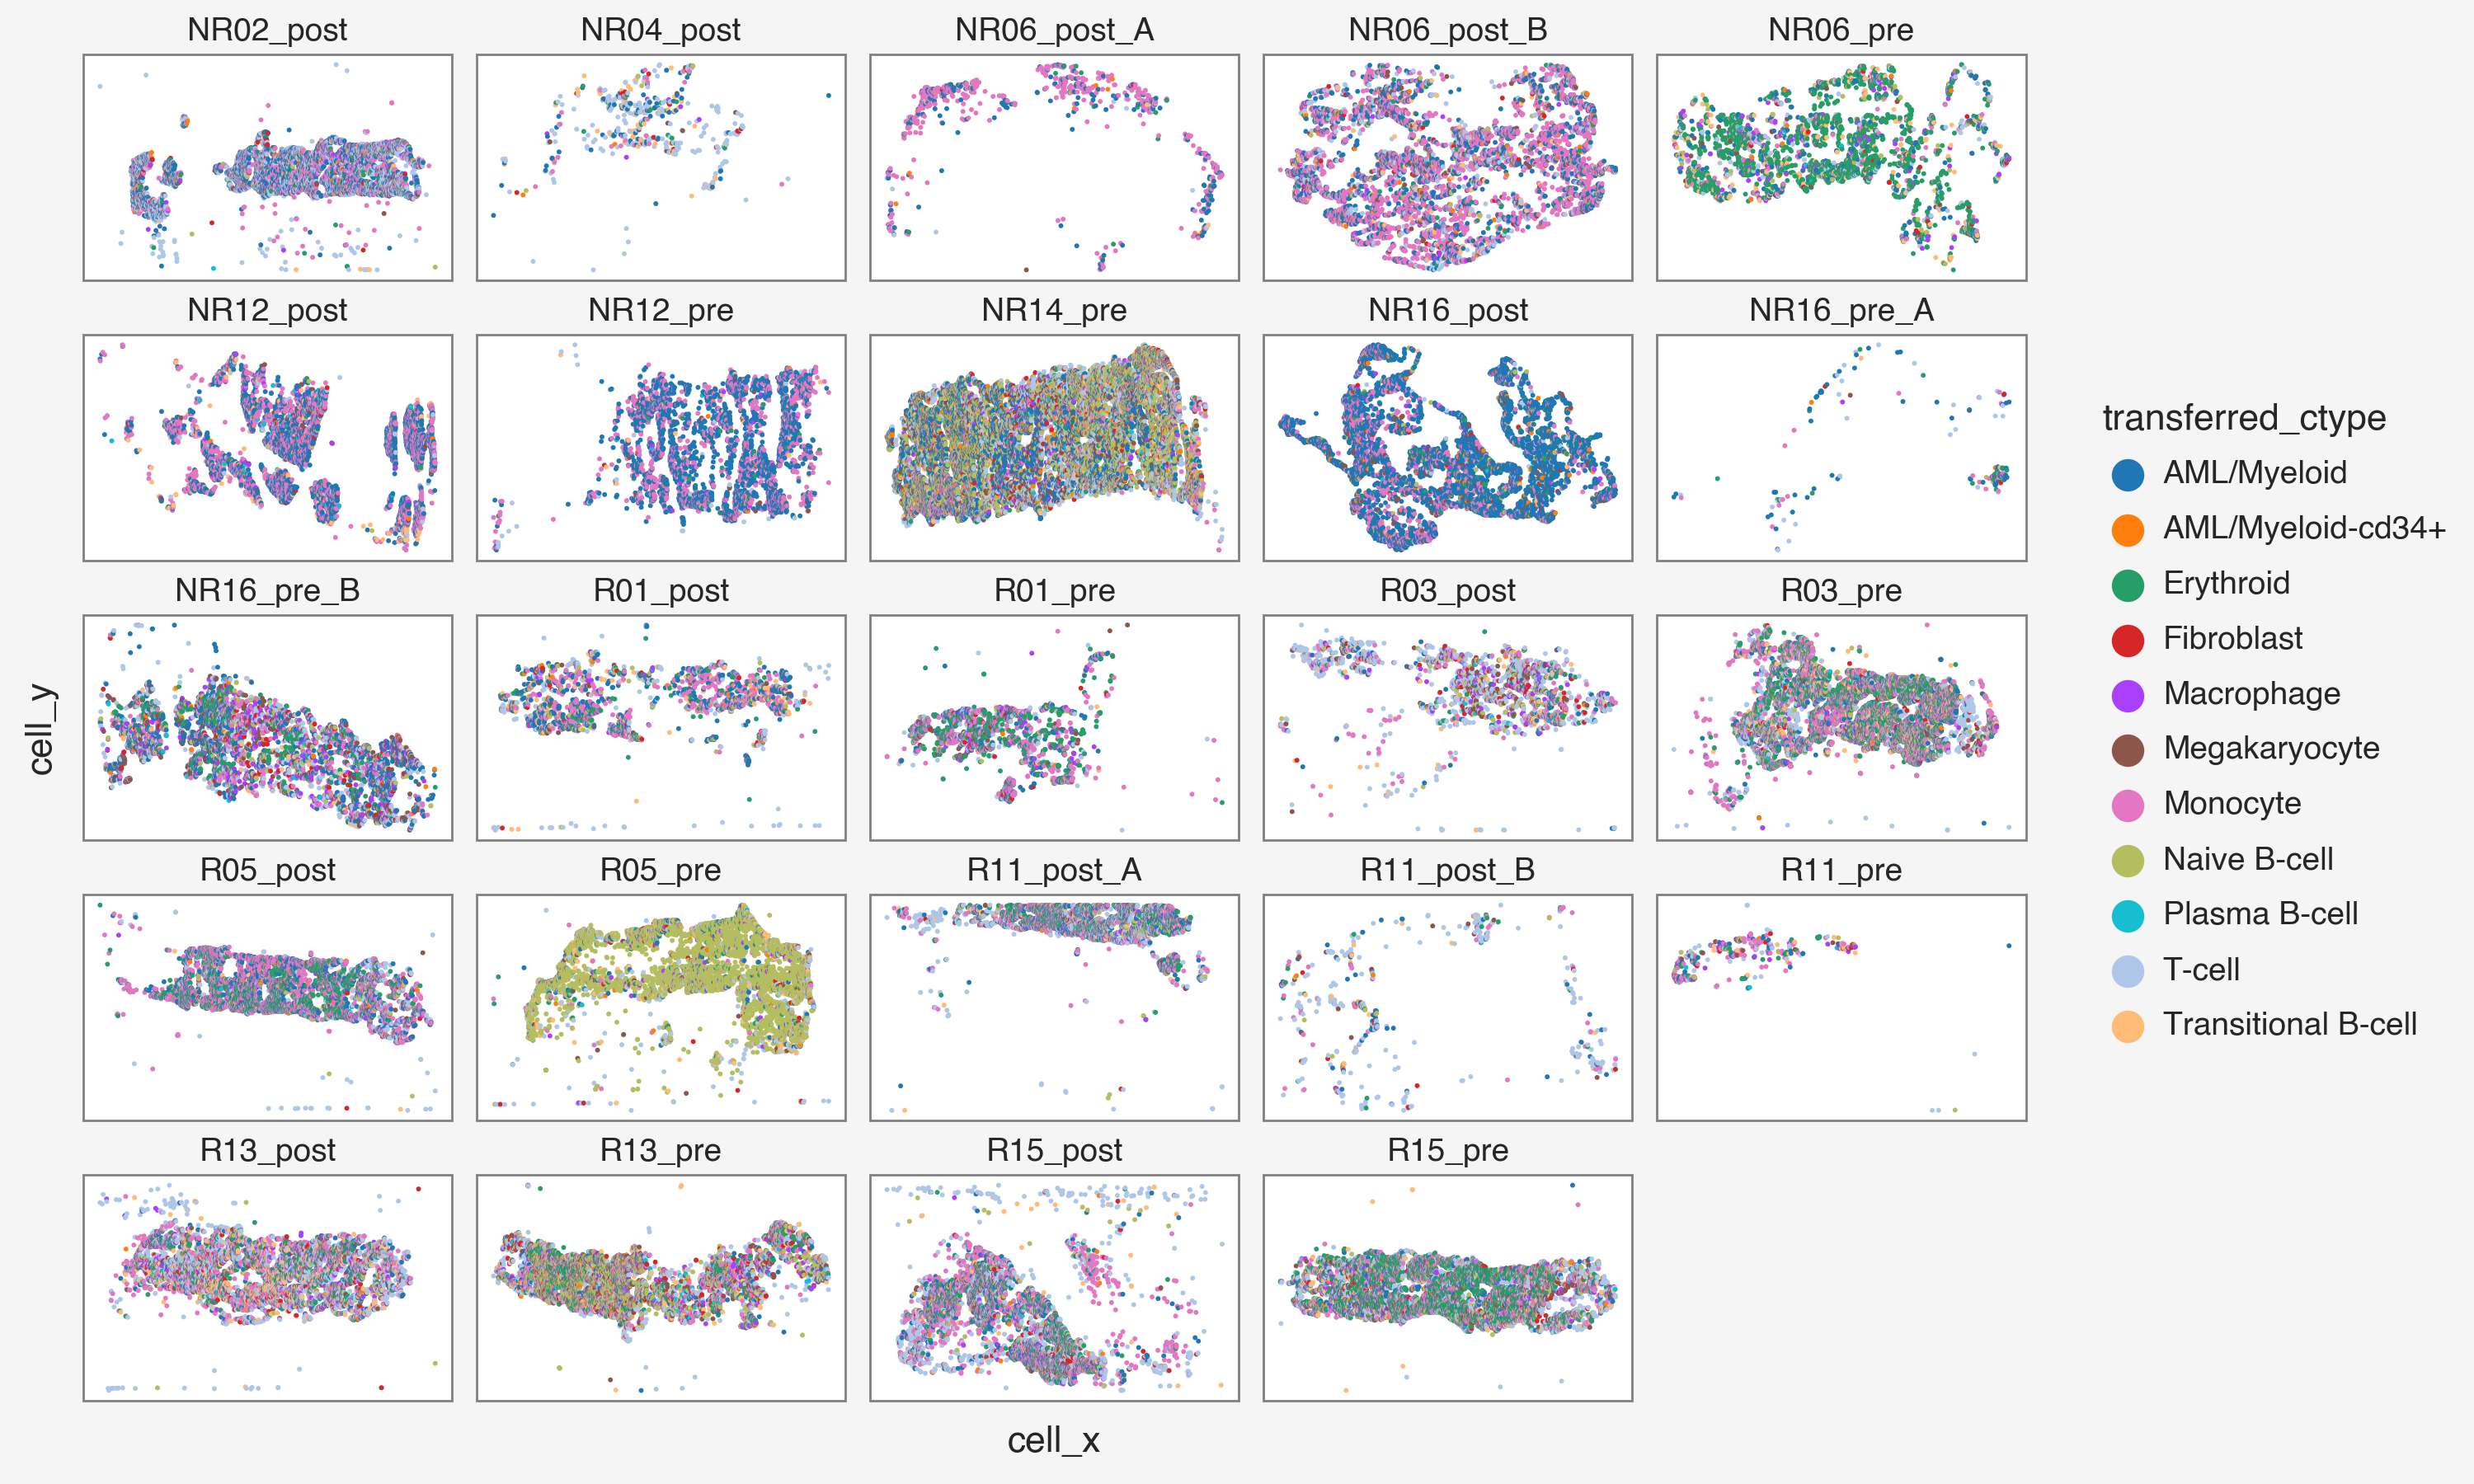

In [5]:
(
    ggplot(adata.obs, aes(x="cell_x", y="cell_y", color="transferred_ctype"))
    + pn.geom_point(size = 0.2)
    + pn.facet_wrap("sample_id", scales="free")
    + pn.coord_fixed()
    + pn.scale_color_manual(values=sc.pl.palettes.default_20)
    + pn.guides(colour = pn.guide_legend(override_aes = {'size':7}))
    + sy.style
    + pn.theme(
        figure_size=[15, 9],
        axis_text=pn.element_blank(),
        axis_ticks=pn.element_blank(),
    )
)

### samples with very sparse tissue will be excluded from spatial downstream analysis

In [6]:
sparse_samples = ['NR04_post', 'NR06_post_A', 'NR16_pre_A', 'R11_pre', 'R11_post_B']
included_samples = list(set(adata.obs['sample_id'].unique()) - set(sparse_samples))

# Spatial metrics

### compute distance matrices and save to disk
for each sample we calulate pairwise euclidean distances of XY coordinates of all cells. This will be the basis for building connectivity graphs and neighborhood analysis

In [9]:
samples = adata.obs['sample_id'].unique()
out_folder = f'{output_path}/spatial_metrics/distance_matrices'

for sample in samples:
    tap1_auxfns.compute_distance_matrix(adata=adata, sample_id=sample, out_folder=out_folder)

### calculate neighborhood graph at large radius from where we can filter down
For each 'query' cell in a sample a euclidean distance cutoff is applied to the previously generated distance matrix. The results are converted into a long form dataframe and annotated with the celltypes for the query cell and its neighboring reference cells 'ref_cell'. I know this is memory intensive and not efficient, but at the time it helped tremendously to filter and understand the data.

For the main output, a large radius (1500px) is chosen which can easily be filtered down for more fine grained results.

In [10]:
radius = 1500

dists = tap1_auxfns.celltype_neighborhood(adata=adata, sample=included_samples[0], radius=radius, celltype='all')

for sample in included_samples:
    if sample != included_samples[0]:
        tmp_dists = tap1_auxfns.celltype_neighborhood(adata=adata, sample=sample, radius=radius, celltype='all')
        dists = dists.vstack(tmp_dists)

dists.write_csv(f'{output_path}/spatial_metrics/connectivity_graphs/connectivities_rad{radius}.csv')
dists.write_csv(f'{output_path}/spatial_metrics/connectivity_graphs/connectivities_rad{radius}.csv.gz')

### calculate neighborhood proportions on cell level across various distances and then summarize on sample level
for each cell neighborhood, the proportion of the various neighboring celltypes are calculated. i.e: if there are 20 cells in a neighborhood, and 10 of them are Myeloid, then the 'observed fraction' (obs_frac) of Myeloid cells in that neighborhood is 0.5. Please note that all potential celltypes are considered. Therefore, celltypes that are not detected in a given neighborhood have obs_frac = 0.

This process is repeating at increasing radii between 0 and 1500.

The restults are then summarized as mean per sample.

In [11]:
radii = list(range(0, 100, 5)) + list(range(100, 500, 25)) + list(range(500, 1550, 50))

In [12]:
pl.Config.set_tbl_rows(20)

df_list = []

dists = pl.read_csv(f'{output_path}/spatial_metrics/connectivity_graphs/connectivities_rad1500.csv')

for radius in radii:
    df_cell = tap1_auxfns.cell_neighborhood_proportions(adata=adata, samples=included_samples, distances=dists, radius=radius, include_zeros=True)
    df_cell.write_csv(f'{output_path}/spatial_metrics/neighborhoods_cell_level/cell_neighborhood_proportions_rad{radius}.csv') 
    
    df_means = df_cell.group_by('sample_id', 'patient', 'timepoint', 'group', 'time_group', 'qry_celltype', 'ref_celltype').agg(pl.mean('obs_frac')).with_columns(pl.lit(radius).alias('radius'))
    df_list.append(df_means)

mean_neighbors = pl.concat(df_list).unique()
mean_neighbors.write_csv(f'{output_path}/spatial_metrics/neighborhoods_sample_level/neighborhoods_avergaged_ranges_0to1500.csv')

In [13]:
dists = pl.read_csv(f'{output_path}/spatial_metrics/connectivity_graphs/connectivities_rad1500.csv')
mean_neighbors = pl.read_csv(f'{output_path}/spatial_metrics/neighborhoods_sample_level/neighborhoods_avergaged_ranges_0to1500.csv') 

### calculate shannon diversity of neighborhoods across various radii
the shannon diversity index is calculated for the neighborhoods of a given celltype in each sample. Like above, the index is calculated at multiple radii.

In [14]:
div_list = []

for radius in radii:
    df_cell = tap1_auxfns.calculate_diversity(distances=dists, samples=included_samples, radius=radius)
    div_list.append(df_cell)

mean_divs = pl.concat(div_list)
mean_divs.write_csv(f'{output_path}/spatial_metrics/shannon_diversity/shannon_diversity_across_radii.csv')

In [15]:
mean_divs = pl.read_csv(f'{output_path}/spatial_metrics/shannon_diversity/shannon_diversity_across_radii.csv')

group_enum = pl.Enum(['pre_NR', 'post_NR', 'pre_R', 'post_R'])
mean_divs = mean_divs.with_columns(pl.col('time_group').cast(dtype=group_enum))
mean_divs

sample_id,patient,timepoint,group,qry_celltype,shann_div,radius,time_group
str,str,str,str,str,f64,i64,enum
"""NR14_pre""","""NR14""","""pre""","""NR""","""CD4 T-cell""",-0.0,10,"""pre_NR"""
"""NR14_pre""","""NR14""","""pre""","""NR""","""AML/Myeloid""",-0.0,10,"""pre_NR"""
"""R03_post""","""R03""","""post""","""R""","""Transitional B-cell""",-0.0,10,"""post_R"""
"""R03_post""","""R03""","""post""","""R""","""Monocyte""",-0.0,10,"""post_R"""
"""R03_post""","""R03""","""post""","""R""","""Megakaryocyte""",-0.0,10,"""post_R"""
"""NR14_pre""","""NR14""","""pre""","""NR""","""Monocyte""",-0.0,10,"""pre_NR"""
"""NR02_post""","""NR02""","""post""","""NR""","""CD4 T-cell""",0.30103,15,"""post_NR"""
"""R03_post""","""R03""","""post""","""R""","""AML/Myeloid""",0.4686,15,"""post_R"""
"""NR12_post""","""NR12""","""post""","""NR""","""Monocyte""",0.451545,15,"""post_NR"""
